In [1]:
# Libraries

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB1
from keras.utils.vis_utils import plot_model

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# others
import pandas as pd
import time
import numpy as np
import random
import os

from PIL import Image
import cv2
from IPython.display import display
from tqdm import tqdm_notebook
import copy # To copy later our best model


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Chemin d'accès ### A MODIFIER EN LOCAL !!
path = "/content/gdrive/MyDrive/Projet Radio DST/"     
ID_DIR = 5

# Accès aux sous-dossiers
dirsi = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]
dirsim = ["Normal/masked_images/","COVID/masked_images/","Lung_Opacity/masked_images/","Viral Pneumonia/masked_images/"]


# Images à traiter (brutes ou masquées) et taille échantillon
dirs = dirsim
ECH_SIZE = 2000 #(max 2000 sur images masquées par seul un échantillon dispo)

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

# Paramètres
SIZE = (240,240)
RATIO_VAL = 0.2
BATCH_SIZE = 32
NB_EPOCHS = 30

In [23]:
train_dir = path
normal_imgs = [fn for fn in os.listdir(path + dirs[0]) if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(path + dirs[1]) if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(path + dirs[2]) if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(path + dirs[3]) if fn.endswith('.png')]

liste = []
liste_test = []

for fn in normal_imgs[0: (ECH_SIZE // nbClasses)] : #Dataframe quilibré sur l'échantillon considéré
    liste.append(path + dirs[0] + fn)
for i in range(100):
    liste_test.append(liste[-100:][i])
liste = liste[:-100]

for fn in covid_imgs[0: (ECH_SIZE // nbClasses)] :
    liste.append(path + dirs[1] + fn)
for i in range(100):
    liste_test.append(liste[-100:][i])
liste = liste[:-100]

for fn in pneumonia_imgs[0: (ECH_SIZE // nbClasses)] :
    liste.append(path + dirs[2] + fn)
for i in range(100):
    liste_test.append(liste[-100:][i])
liste = liste[:-100]

for fn in lung_opacity_imgs[0: (ECH_SIZE // nbClasses)] :
    liste.append(path + dirs[3] + fn)
for i in range(100):
    liste_test.append(liste[-100:][i])
liste = liste[:-100]


liste = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste)) 
liste_test = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste_test)) 
"""Le chiffre '6' est à changer en fonction de la longueur du path, le but est de recupérer les termes "nomrals", "covid",... """

#Créer un DataFrame Entrainement et validation
df = pd.DataFrame(liste, columns = ['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df = df.drop(['nameLabel'], axis=1)
df['label'] = df['label'].astype(str)

df =  df.sample(frac=1, random_state=42) #Mélange du dataframe
df = df.reset_index(drop=True)

#Créer un DataFrame de test (commun pour tous les modèles)
df_test = pd.DataFrame(liste_test, columns = ['filepath', 'nameLabel'])
df_test['label'] = df_test['nameLabel'].replace(df_test.nameLabel.unique(), [*range(len(df_test.nameLabel.unique()))])
df_test = df_test.drop(['nameLabel'], axis=1)
df_test['label'] = df_test['label'].astype(str)

df

,filepath,label
0,/content/gdrive/MyDrive/Projet Radio DST/COVID...,1
1,/content/gdrive/MyDrive/Projet Radio DST/Norma...,0
2,/content/gdrive/MyDrive/Projet Radio DST/Norma...,0
3,/content/gdrive/MyDrive/Projet Radio DST/Norma...,0
4,/content/gdrive/MyDrive/Projet Radio DST/Lung_...,2
...,...,...
1595,/content/gdrive/MyDrive/Projet Radio DST/Lung_...,2
1596,/content/gdrive/MyDrive/Projet Radio DST/Viral...,3
1597,/content/gdrive/MyDrive/Projet Radio DST/Lung_...,2
1598,/content/gdrive/MyDrive/Projet Radio DST/Viral...,3


In [27]:
df.value_counts("label")

label
0    400
1    400
2    400
3    400
dtype: int64

In [28]:
df_test.value_counts("label")

label
0    100
1    100
2    100
3    100
dtype: int64

In [30]:
# Séparation dataframe en ensemble entraiement et validation
train, valid = train_test_split(df, test_size=RATIO_VAL, shuffle = False)


# Création des itérateurs qui chargeront des lots d'images
train_data_generator = ImageDataGenerator( )
valid_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Initialisation du image generator de train
print(f"Number of rows in train set: {len(train)}")
train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = SIZE, #Resize
                                                           batch_size = BATCH_SIZE,
                                                           #color_mode = "grayscale"
                                                           ) 

# Initialisation du image generator de validation
print(f"Number of rows in valid set: {len(valid)}")
valid_generator = valid_data_generator.flow_from_dataframe(dataframe = valid,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE,
                                                         #color_mode = "grayscale", # Pas de grayscale, en rgb !
                                                         shuffle = False)                                                         

# Initialisation du image generator de test
print(f"Number of rows in test set: {len(df_test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test, #Utilisation du dataframe de test
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE,
                                                         #color_mode = "grayscale", # Pas de grayscale, en rgb !
                                                         shuffle = False) 



Number of rows in train set: 1280
Found 1280 validated image filenames belonging to 4 classes.
Number of rows in valid set: 320
Found 320 validated image filenames belonging to 4 classes.
Number of rows in test set: 400
Found 400 validated image filenames belonging to 4 classes.


In [ ]:
#Chargement et freeze modèle de base VERSION SEQUENTIELLE
base_model = EfficientNetB1(include_top=False, input_shape=(240,240,3))
for layer in base_model.layers :
    layer.trainable = False

# Instanciation modèle séquentiel
model = Sequential()

# Ajout des différentes couches
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = "relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = "relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 4, activation = "softmax"))


# Compilation
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

27018416/27018416 [==============================] - 0s 0us/step


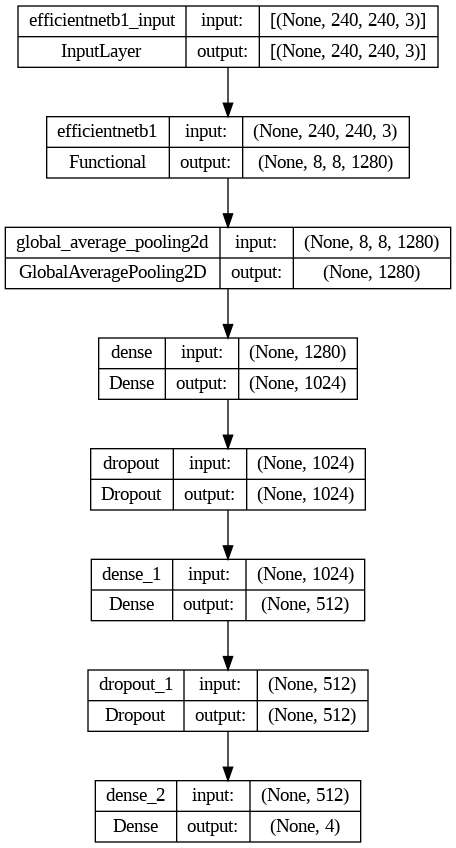

In [ ]:
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Entrainement du modèle
train_size = train_generator.samples
valid_size = valid_generator.samples

history = model.fit(train_generator,
                              epochs = NB_EPOCHS,
                              steps_per_epoch = train_size // BATCH_SIZE,
                              validation_data = valid_generator,
                              validation_steps = valid_size // BATCH_SIZE)

Epoch 1/30
34/34 [==============================] - 439s 12s/step - loss: 0.9289 - accuracy: 0.5930 - val_loss: 0.5073 - val_accuracy: 0.8185
Epoch 2/30
34/34 [==============================] - 6s 167ms/step - loss: 0.5904 - accuracy: 0.7675 - val_loss: 0.5052 - val_accuracy: 0.7857
Epoch 3/30
34/34 [==============================] - 7s 196ms/step - loss: 0.4905 - accuracy: 0.7904 - val_loss: 0.5652 - val_accuracy: 0.7887
Epoch 4/30
34/34 [==============================] - 8s 231ms/step - loss: 0.4869 - accuracy: 0.7961 - val_loss: 0.4422 - val_accuracy: 0.8274
Epoch 5/30
34/34 [==============================] - 6s 169ms/step - loss: 0.4087 - accuracy: 0.8369 - val_loss: 0.4735 - val_accuracy: 0.8125
Epoch 6/30
34/34 [==============================] - 6s 173ms/step - loss: 0.3915 - accuracy: 0.8512 - val_loss: 0.4889 - val_accuracy: 0.8482
Epoch 7/30
34/34 [==============================] - 7s 219ms/step - loss: 0.4669 - accuracy: 0.8197 - val_loss: 0.3769 - val_accuracy: 0.8661
Epoch 

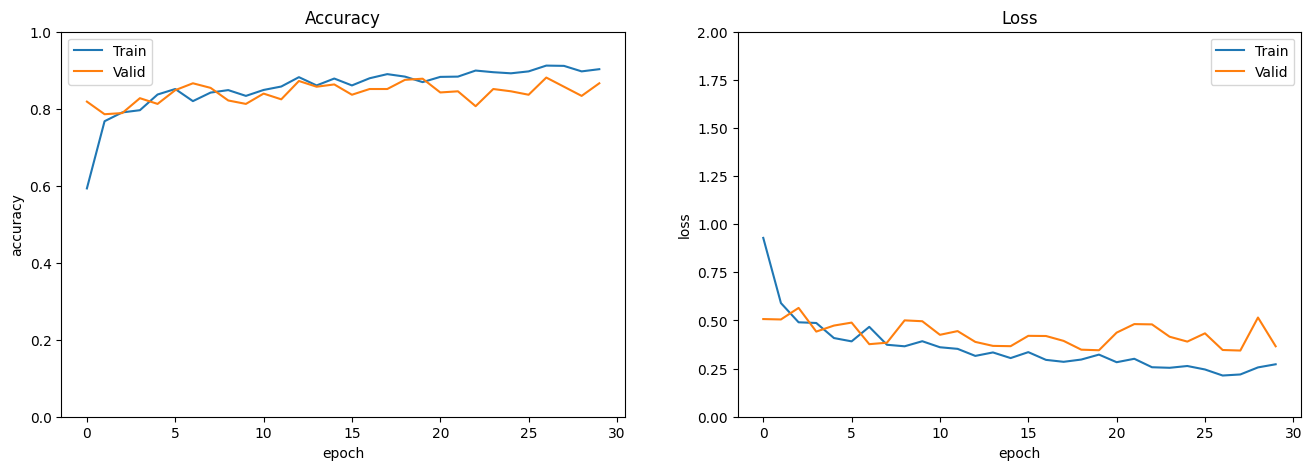

In [ ]:
# Courbes d'accuracy et de perte
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Valid")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("Accuracy")

plt.subplot(122)
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Valid")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,2)
plt.title("Loss")
plt.show();

In [ ]:
# Calcul des prédictions (probabilités)
test_pred = model.predict(test_generator, verbose = 1 )

5/5 [==============================] - 44s 9s/step


In [ ]:
# Récupération des classes à partir des probabilités
test_pred_class = test_pred.argmax(axis = 1)

# Matrice de confusion
print(confusion_matrix(test_generator.classes, test_pred_class))

[[45  1  3  1]
 [ 4 38  9  0]
 [ 1  6 46  0]
 [ 5  0  1 40]]


[[45  1  3  1]
 [ 4 38  9  0]
 [ 1  6 46  0]
 [ 5  0  1 40]]


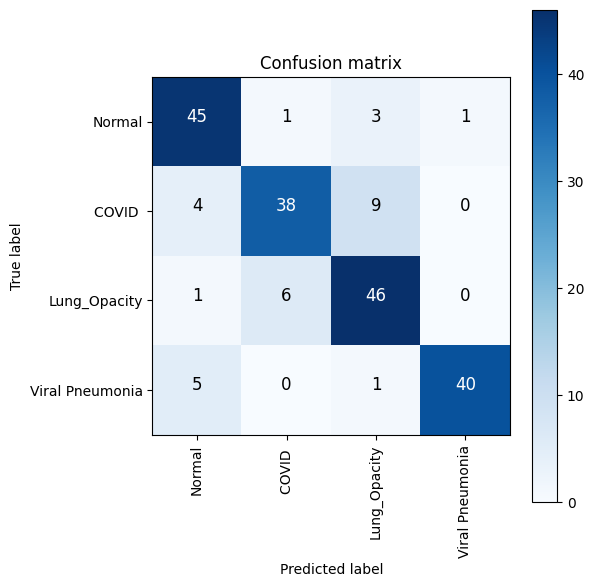

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
      
#get confusion matrix
cm = confusion_matrix(test_generator.classes, test_pred_class)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
print(classification_report(test_generator.classes, test_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.84      0.75      0.79        51
           2       0.78      0.87      0.82        53
           3       0.98      0.87      0.92        46

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.84      0.85       200



In [ ]:
model.save_weights("/content/gdrive/MyDrive/Projet Radio DST/model_efnet1_2000imk_30ep.h5")

In [ ]:
model.load_weights("/content/gdrive/MyDrive/Projet Radio DST/model_efnet1_2000imk_30ep.h5")